# Диагностическая работа по датасету CubeSat in Space

## Займёмся подготовкой необходимым данных, библиотек и переменных

### Установим датасет через kagglehub

In [1]:
# !pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eberhardtkorf/synthetic-cubesat")

print("Path to dataset files:", path)

Path to dataset files: /home/sasha/.cache/kagglehub/datasets/eberhardtkorf/synthetic-cubesat/versions/1


### Импортируем библиотеки, определим пути и настройки отображения matplotlib

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import json
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from scipy.spatial.transform import Rotation as R

import warnings
warnings.filterwarnings("ignore")

# Настройки логгера
logger = logging.getLogger('cubesat_log')

# Настройки для отображения
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [4]:
dataset_path = Path(path + '/synthetic_cubesat' + '/dataset')

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

train_img_dir = os.path.join(train_dir, 'images')
test_img_dir = os.path.join(test_dir, 'images')

train_csv_path = os.path.join(train_dir, 'train_ground_truth.csv')
test_csv_path = os.path.join(test_dir, 'test_ground_truth.csv')

### Подгружаем данные

In [5]:
class CubeSatPoseDataset(Dataset):
    """
    Dataset для загрузки изображений кубсатов и их поз (позиция + ориентация).
    
    Args:
        csv_path (str): Путь к CSV файлу с метаданными
        images_dir (str): Директория с изображениями
        transform (callable, optional): Трансформации для изображений
        target_transform (callable, optional): Трансформации для целевых переменных
    """
    
    def __init__(self, csv_path, images_dir, transform=None, 
                 target_transform=None, img_size=(224, 224)):
        self.df = pd.read_csv(csv_path)
        self.images_dir = Path(images_dir)
        self.transform = transform
        self.target_transform = target_transform
        
        # Проверяем существование изображений
        self.valid_indices = []
        for idx, row in self.df.iterrows():
            img_path = self.images_dir / row['IMG_NUM']
            if img_path.exists():
                self.valid_indices.append(idx)
            else:
                logger.error(f"Изображение не найдено: {img_path}")
        
        print(f"[INFO] Загружено {len(self.valid_indices)} корректных записей из {len(self.df)}")
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        # Получаем реальный индекс
        real_idx = self.valid_indices[idx]
        row = self.df.iloc[real_idx]
        
        # Загружаем изображение
        img_path = self.images_dir / row['IMG_NUM']
        image = Image.open(img_path).convert('RGB')
        
        # Применяем трансформации к изображению
        if self.transform:
            image = self.transform(image)

        # Выбираем целевые значения
        roll  = np.deg2rad(row["ROLL"])
        pitch = np.deg2rad(row["PITCH"])
        yaw   = np.deg2rad(row["YAW"])
        
        target = np.array([
            row["X"],
            row["Y"],
            row["Z"],
        
            np.sin(roll),  np.cos(roll),
            np.sin(pitch), np.cos(pitch),
            np.sin(yaw),   np.cos(yaw),
        ], dtype=np.float32)

        # Применяем трансформации к целевой переменной
        if self.target_transform:
            target = self.target_transform(target)
        
        return (image, torch.from_numpy(target))
    
    def get_raw_item(self, idx):
        """Получить сырые данные без трансформаций (для отладки)"""
        real_idx = self.valid_indices[idx]
        row = self.df.iloc[real_idx]
        img_path = self.images_dir / row['IMG_NUM']
        image = Image.open(img_path).convert('RGB')
        return image, row

In [6]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])]  # ImageNet нормализация
                              )

train_dataset = CubeSatPoseDataset(
    csv_path=train_csv_path,
    images_dir=train_img_dir,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4
)

test_dataset = CubeSatPoseDataset(
    csv_path=test_csv_path,
    images_dir=test_img_dir,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4
)

[INFO] Загружено 7998 корректных записей из 7998
[INFO] Загружено 2000 корректных записей из 2000


### Визуализируем данные

In [7]:
def im_show(img_list) -> None:
    """
    Простая визуализация изображений с параметрами позы.
    
    :param img_list: список кортежей (image_tensor, pose_vector)
    """
    
    num_images = len(img_list)
    
    # Создаем сетку 2 x num_images
    fig, axes = plt.subplots(2, num_images, figsize=(4*num_images, 8))
    
    to_PIL = transforms.ToPILImage()
    
    for idx, (img_tensor, pose) in enumerate(img_list):
        # Верхний ряд: изображения
        if torch.is_tensor(img_tensor):
            # Конвертируем тензор в PIL Image
            img_pil = to_PIL(img_tensor)
            axes[0, idx].imshow(img_pil)
        else:
            axes[0, idx].imshow(img_tensor)
        
        axes[0, idx].axis('off')
        
        # Нижний ряд: параметры позы
        if torch.is_tensor(pose):
            pose_np = pose.detach().cpu().numpy()
        else:
            pose_np = pose.to_numpy() if hasattr(pose, "to_numpy") else np.array(pose)
    
        # Создаем текстовое представление
        pose_text = ""
        param_names = ['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']
        
        for i in range(0, 6):
            pose_text += f"{param_names[i]}: {pose_np[i+1]}\n"
        
        
        axes[1, idx].text(0.5, 0.5, pose_text,
                         ha='center', va='center',
                         transform=axes[1, idx].transAxes,
                         fontsize=10,
                         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

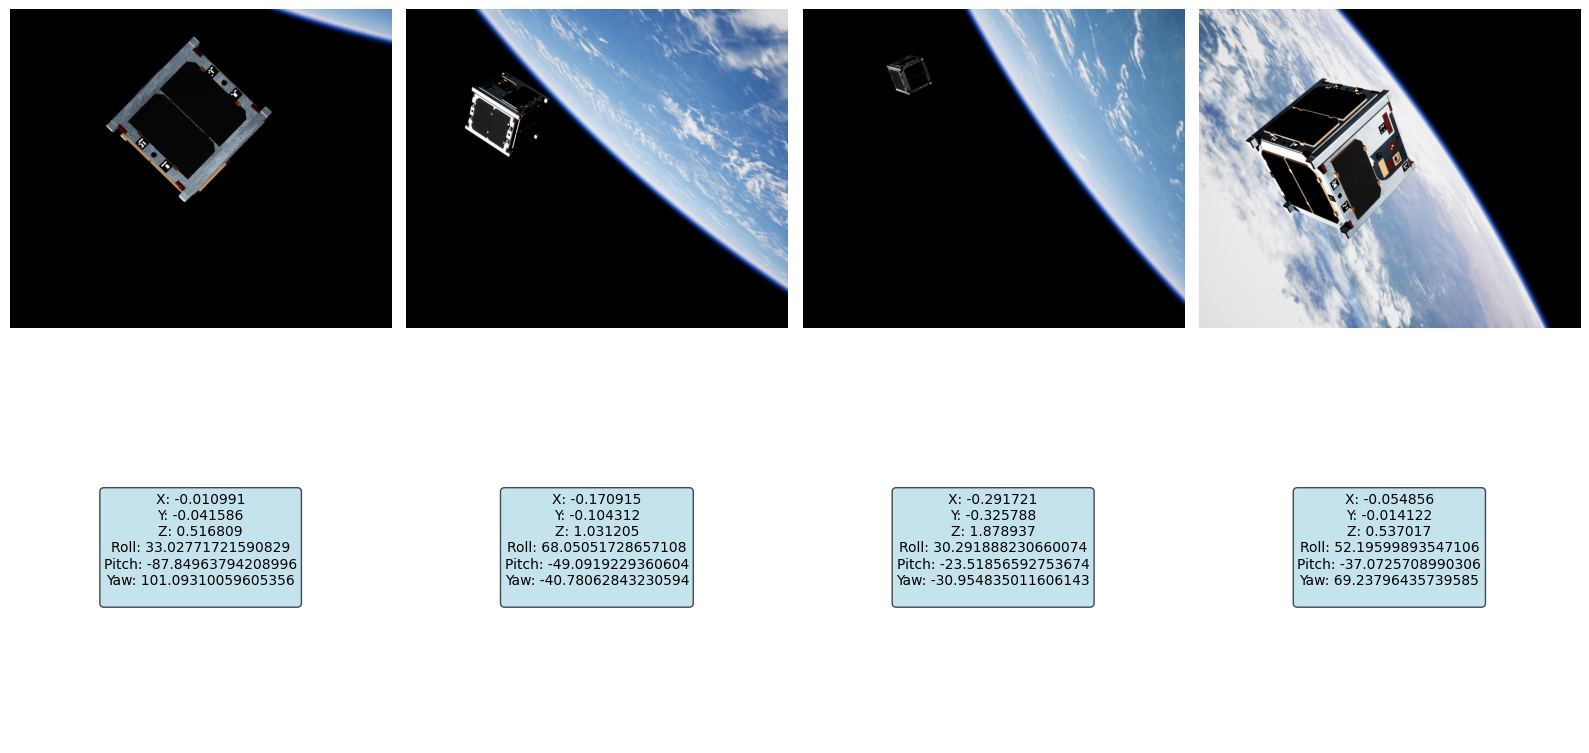

In [8]:
img_list = []
for i in range(4):
    idx = np.random.randint(0, len(train_dataset))
    img, label = train_dataset.get_raw_item(idx)
    img_list.append((img, label))

im_show(img_list)

## Создадим модель на основе ResNet18 (Transfer learning) используя pytorch_lightning

In [9]:
import torch.nn as nn
from torchvision import models
import pytorch_lightning as pl

class CubeSatPoseModel(pl.LightningModule):
    """
    Модель для pose estimation кубсата.
    Использует предобученный ResNet18 и заменяет последние слои.
    """
    
    def __init__(self, num_outputs=6, lr: float = 0.001):
        super(CubeSatPoseModel, self).__init__()
        self.lr = lr
        self.save_hyperparameters()
        
        # Берем предобученный ResNet18
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.backbone = models.resnet18(weights=weights)

        # Сохраняем количество фичей перед заменой fc слоя
        num_features = self.backbone.fc.in_features
        
        # Удаляем последний полносвязный слой
        self.backbone.fc = nn.Identity()

        for name, param in self.backbone.named_parameters():
            if "layer4" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Добавляем свои слои для регрессии
        self.regressor = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, num_outputs)
        )

        # Функция потерь - MSE для регрессии
        self.criterion = nn.SmoothL1Loss()
    
    def forward(self, x):
        # Извлекаем признаки
        features = self.backbone(x)
        
        # Предсказываем позу
        pose = self.regressor(features)
        return pose

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.criterion(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, targets = val_batch
        preds = self(images)
    
        loss = self.criterion(preds, targets)
    
        # MAE по каждому параметру (X, Y, Z, Roll, Pitch, Yaw)
        mae = torch.mean(torch.abs(preds - targets), dim=0)  # dim=0 = среднее по батчу
    
        self.log("val_loss", loss, prog_bar=True)
        self.log("mae_x", mae[0].item())
        self.log("mae_y", mae[1].item())
        self.log("mae_z", mae[2].item())
        self.log("mae_roll", mae[3].item())
        self.log("mae_pitch", mae[4].item())
        self.log("mae_yaw", mae[5].item())
    
        return loss


In [10]:
model = CubeSatPoseModel(num_outputs=9, lr=3e-4)
print(model)

CubeSatPoseModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

### Обучим модель

In [11]:
from pytorch_lightning.loggers import CSVLogger

logger_pl = CSVLogger("logs", name="cubesat")

trainer = pl.Trainer(accelerator="auto", max_epochs=20, devices=1, logger=logger_pl)
trainer.fit(model, train_loader, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode  | FLOPs
-----------------------------------------------------------
0 | backbone  | ResNet       | 11.2 M | train | 0    
1 | regressor | Sequential   | 166 K  | train | 0    
2 | criterion | SmoothL1Loss | 0      | train | 0    
-----------------------------------------------------------
8.6 M     Trainable params
2.8 M     Non-trainable params
11.3 M    Total params
45.371    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


### Проверим модель

In [16]:
def show_predictions(model, dataloader, num_images=4):
    model.eval()
    imgs_shown = 0

    fig, axes = plt.subplots(2, num_images, figsize=(5*num_images, 8))

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(model.device)
            targets = targets.to(model.device)

            preds = model(images)

            for i in range(images.size(0)):
                if imgs_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())

                gt = targets[i].cpu().numpy()
                pr = preds[i].cpu().numpy()

                # ВОССТАНОВЛЕНИЕ УГЛОВ
                def decode_angles(v):
                    roll  = np.rad2deg(np.arctan2(v[3], v[4]))
                    pitch = np.rad2deg(np.arctan2(v[5], v[6]))
                    yaw   = np.rad2deg(np.arctan2(v[7], v[8]))
                    return roll, pitch, yaw

                gt_roll, gt_pitch, gt_yaw = decode_angles(gt)
                pr_roll, pr_pitch, pr_yaw = decode_angles(pr)

                gt_xyz = gt[:3]
                pr_xyz = pr[:3]

                axes[0, imgs_shown].imshow(img)
                axes[0, imgs_shown].axis("off")
                axes[0, imgs_shown].set_title("IMAGE")

                text = (
                    f"GT:\n"
                    f"X={gt_xyz[0]:.2f}, Y={gt_xyz[1]:.2f}, Z={gt_xyz[2]:.2f}\n"
                    f"R={gt_roll:.1f}°, P={gt_pitch:.1f}°, Y={gt_yaw:.1f}°\n\n"
                    f"PRED:\n"
                    f"X={pr_xyz[0]:.2f}, Y={pr_xyz[1]:.2f}, Z={pr_xyz[2]:.2f}\n"
                    f"R={pr_roll:.1f}°, P={pr_pitch:.1f}°, Y={pr_yaw:.1f}°"
                )

                axes[1, imgs_shown].text(
                    0.5, 0.5, text,
                    ha="center", va="center",
                    fontsize=11,
                    transform=axes[1, imgs_shown].transAxes,
                    bbox=dict(boxstyle="round", facecolor="lightblue")
                )
                axes[1, imgs_shown].axis("off")

                imgs_shown += 1


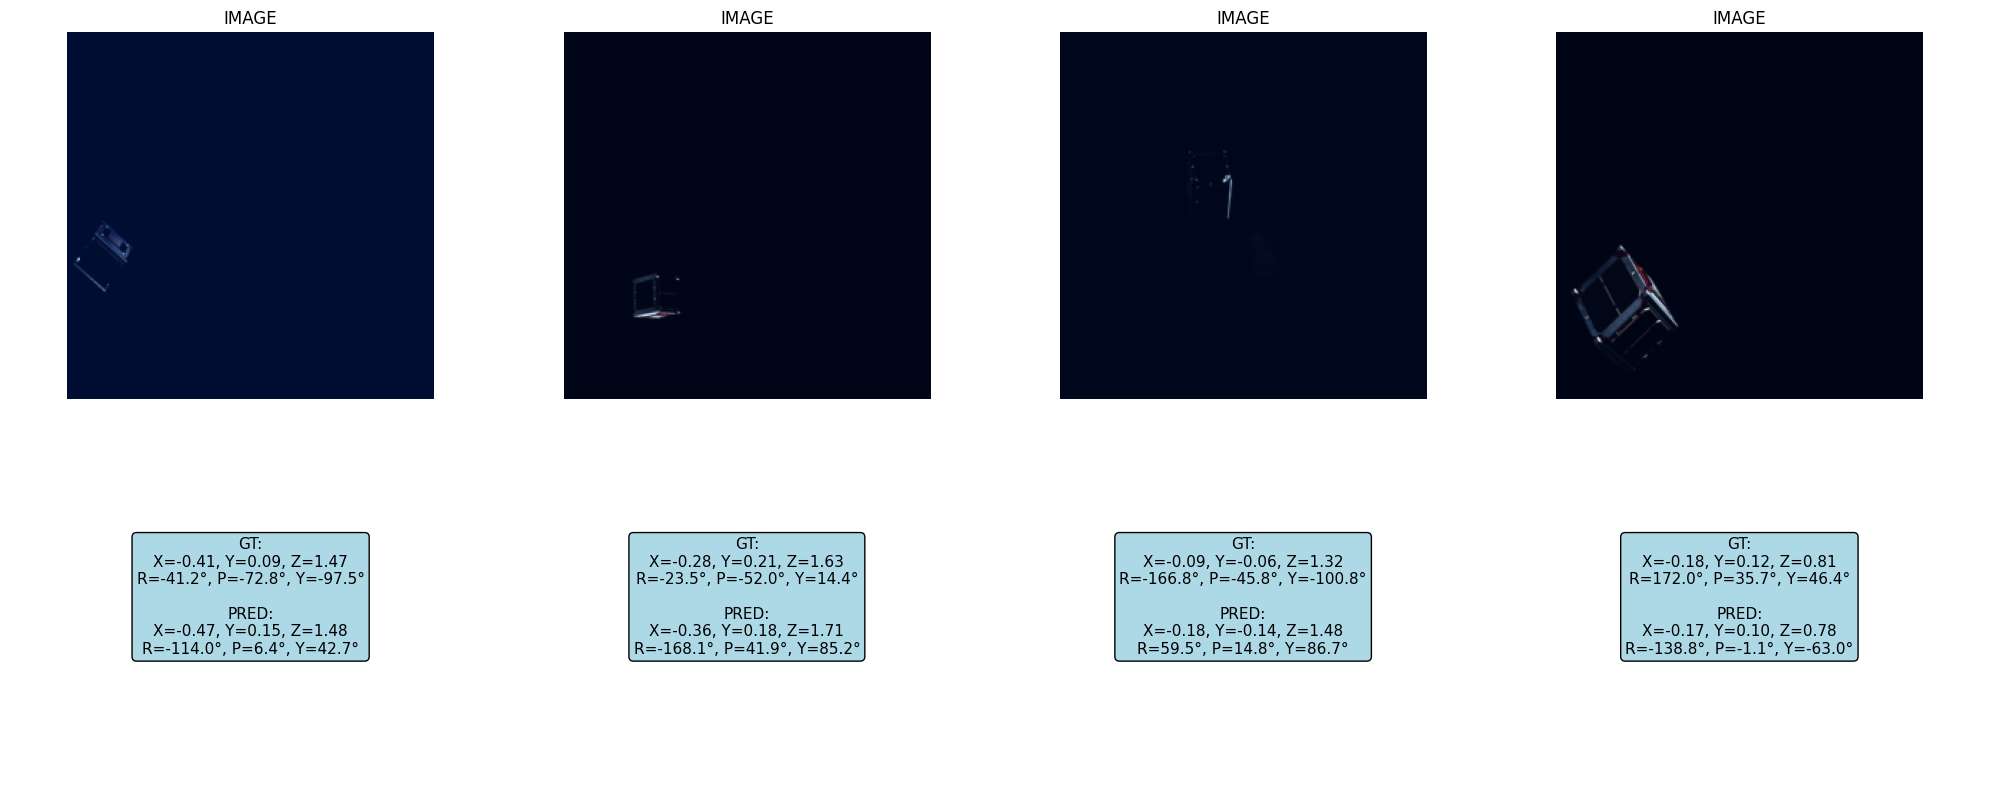

In [20]:
show_predictions(model, test_loader, num_images=4)

In [14]:
def evaluate_real_mae(model, dataloader):
    model.eval()

    pos_err = []
    rot_err = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(model.device)
            targets = targets.to(model.device)

            preds = model(images)

            preds = preds.cpu().numpy()
            targets = targets.cpu().numpy()

            # ПОЗИЦИЯ
            pos_mae = np.mean(np.abs(preds[:, :3] - targets[:, :3]), axis=0)
            pos_err.append(pos_mae)

            # УГЛЫ
            def decode_batch(v):
                roll  = np.rad2deg(np.arctan2(v[:, 3], v[:, 4]))
                pitch = np.rad2deg(np.arctan2(v[:, 5], v[:, 6]))
                yaw   = np.rad2deg(np.arctan2(v[:, 7], v[:, 8]))
                return np.stack([roll, pitch, yaw], axis=1)

            pred_ang = decode_batch(preds)
            targ_ang = decode_batch(targets)

            rot_mae = np.mean(np.abs(pred_ang - targ_ang), axis=0)
            rot_err.append(rot_mae)

    pos_err = np.mean(pos_err, axis=0)
    rot_err = np.mean(rot_err, axis=0)

    print("MAE:")
    print(f"X = {pos_err[0]:.3f} m")
    print(f"Y = {pos_err[1]:.3f} m")
    print(f"Z = {pos_err[2]:.3f} m")
    print(f"Roll  = {rot_err[0]:.2f}°")
    print(f"Pitch = {rot_err[1]:.2f}°")
    print(f"Yaw   = {rot_err[2]:.2f}°")


In [15]:
evaluate_real_mae(model, test_loader)

MAE:
X = 0.063 m
Y = 0.054 m
Z = 0.122 m
Roll  = 94.16°
Pitch = 46.73°
Yaw   = 110.38°
